# IDH

In [1]:
%matplotlib inline
import pandas as pd
import requests as req
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols, mixedlm, gee
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLSResults
from patsy import dmatrix

np.set_printoptions(precision=3)

### Carregando dados de IDH-M da Wikipedia

#### Fontes

Estados: http://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_IDH

In [2]:
idhm_df = pd.read_csv("../data/brazil_states_idh_2000_2010.csv", index_col=0)
idhm_df

,Estado,I2000,I2010,Ratio,idh_level_2000
0,Distrito Federal,0.725,0.824,1.136552,1
1,São Paulo,0.702,0.783,1.115385,1
2,Santa Catarina,0.674,0.774,1.148368,1
3,Rio de Janeiro,0.664,0.761,1.146084,1
4,Paraná,0.650,0.749,1.152308,1
5,Rio Grande do Sul,0.664,0.746,1.123494,1
6,Espírito Santo,0.640,0.740,1.156250,1
7,Goiás,0.615,0.735,1.195122,1
8,Minas Gerais,0.624,0.731,1.171474,1
9,Mato Grosso do Sul,0.613,0.729,1.189233,1


### Análise

In [3]:
idhm_df.describe()

,I2000,I2010,Ratio,idh_level_2000
count,27.000000,27.000000,27.000000,27.000000
mean,0.576407,0.704519,1.230795,0.518519
std,0.072960,0.049284,0.072885,0.509175
min,0.471000,0.631000,1.115385,0.000000
25%,0.517500,0.664000,1.163862,0.000000
50%,0.552000,0.699000,1.237132,1.000000
75%,0.632000,0.737500,1.286989,1.000000
max,0.725000,0.824000,1.342437,1.000000


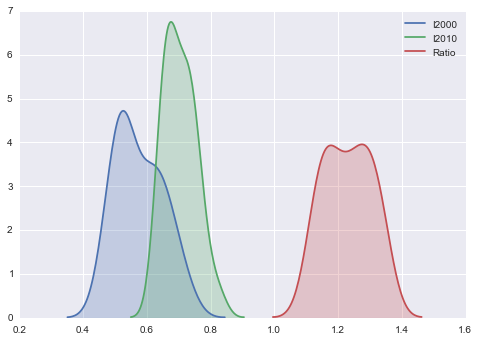

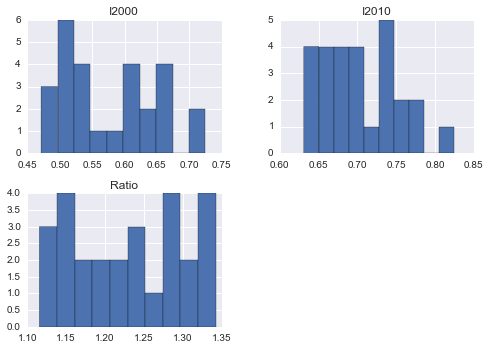

In [4]:
f = plt.figure(14)
idhm_df[["I2000","I2010","Ratio"]].hist(bins=10)
plt.figure()
sns.kdeplot(idhm_df["I2000"], shade=True);
sns.kdeplot(idhm_df["I2010"], shade=True);
sns.kdeplot(idhm_df["Ratio"], shade=True);

In [5]:
sns.factorplot("Regiao","Ratio",data=df, kind="box")

NameError: name 'df' is not defined

In [ ]:
sns.factorplot("idh_level_2000","Ratio",data=df, kind="box")

### Testando hipótese

#### A diferença média entre os IDHs de 2000 e 2010 é estatisticamente significativa?

In [ ]:
ttest_rel(idhm_df['I2000'], idhm_df['I2010'])

In [ ]:
import scipy  
import scikits.bootstrap as bootstrap
  
# compute 95% confidence intervals around the mean  
CIs00 = bootstrap.ci(data=idhm_df["I2000"])  
CIs10 = bootstrap.ci(data=idhm_df["I2010"])
CIsR  = bootstrap.ci(data=idhm_df["Ratio"])

print("IDHM 2000 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

In [ ]:
CIs00 = bootstrap.ci(data=idhm_df["I2000"], statfunction=scipy.median)  
CIs10 = bootstrap.ci(data=idhm_df["I2010"], statfunction=scipy.median)
CIsR  = bootstrap.ci(data=idhm_df["Ratio"], statfunction=scipy.median)

print("IDHM 2000 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

A resposta de diversos testes, para um nível de 5% de significância, mostra que há fortes evidências que **sim**.

### Montando percentual de impacto da administração de cada partido em cada Estado da Federação.

In [ ]:
state_parties = pd.DataFrame({"Estado":idhm_df.Estado,"PT":np.repeat(0.0,27),"PSDB":np.repeat(0.0,27),"Outros":np.repeat(0.0,27)})

In [ ]:
st_pa = np.array([
        [u"Distrito Federal", 0.0, 0.0, 1.0],
        [u"São Paulo", 0.0, 0.925, 0.075],
        [u"Santa Catarina", 0.0, 0.0, 1.0],
        [u"Rio de Janeiro", 0.4, 0.0, 0.6],
        [u"Paraná", 0.0, 0.0, 1.0],
        [u"Rio Grande do Sul", 0.2, 0.4, 0.4],
        [u"Espírito Santo", 0.0, 0.2, 0.8],
        [u"Goiás", 0.0, 0.6, 0.4],
        [u"Minas Gerais", 0.0, 0.8, 0.2],
        [u"Mato Grosso do Sul", 0.0, 0.6, 0.4],
        [u"Mato Grosso", 0.0, 0.2, 0.8],
        [u"Amapá", 0.075, 0.0, 0.925],
        [u"Roraima", 0.275, 0.4, 0.325], # double check
        [u"Tocantins", 0.0, 0.2, 0.8], 
        [u"Rondônia", 0.0, 0.4, 0.6],
        [u"Rio Grande do Norte", 0.0, 0.0, 1.0],
        [u"Ceará", 0.6, 0.0, 0.4],
        [u"Amazonas", 0.0, 0.0, 1.0],
        [u"Pernambuco", 0.0, 0.0, 1.0],
        [u"Sergipe", 0.4, 0.2, 0.4],
        [u"Acre", 1.0, 0.0, 0.0],
        [u"Bahia", 0.4, 0.0, 0.6],
        [u"Paraíba", 0.0, 0.55, 0.45],
        [u"Piauí", 0.8, 0.0, 0.2],
        [u"Pará", 0.4, 0.6, 0.0],
        [u"Maranhão", 0.0, 0.0, 1.0],
        [u"Alagoas", 0.0, 0.0, 1.0],
       ])

Sanity checks

In [ ]:
np.float64(st_pa[:,1:]).sum(axis=1)

In [ ]:
np.float64(st_pa[:,1:]).sum(axis=0)

In [ ]:
#state_parties_df = pd.DataFrame({"Estado":st_pa[:,0],"PSDB":np.float64(st_pa[:,2]),"PT":np.float64(st_pa[:,1]),"Outros":np.float64(st_pa[:,3])})
state_parties_df = pd.read_csv("../data/brazil_states_parties_2000-2010.csv", index_col=0)


In [ ]:
state_parties_df

In [ ]:
state_regions_df = pd.read_csv("../data/brazil_states_regions.csv", index_col=0)
state_regions_df

In [ ]:
df = idhm_df.merge(state_parties_df, on="Estado")
df = df.merge(state_regions_df, on="Estado")
df

In [ ]:
sns.set()
sns.pairplot(df, hue="idh_level_2000", size=2.5)

In [ ]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");

In [ ]:
sns.coefplot("Ratio ~ Outros==0 + Outros - 1", df, palette="Set1");

In [ ]:
sns.set(style="whitegrid")
sns.residplot(df.Outros,df.Ratio, color="navy", lowess=True, order=1)

In [ ]:
sns.coefplot("Ratio ~ PT==0 + PT - 1", df, palette="Set1");

In [ ]:
sns.set(style="whitegrid")
sns.residplot(df[df.PT>0].PT, df[df.PT>0].Ratio, color="navy", order=1)

In [ ]:
sns.coefplot("Ratio ~ PSDB==0 + PSDB + np.multiply(PSDB, PSDB) - 1", df, palette="Set1");

In [ ]:
sns.set(style="whitegrid")
sns.residplot(df[df.PSDB>0].PSDB, df[df.PSDB>0].Ratio, color="navy", lowess=True, order=2)

### Impacto por partido ou nível do IDH-M em 2000

In [ ]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");
sns.coefplot("Ratio ~ PT + PSDB + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("Ratio ~ PT + Outros + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("Ratio ~ PSDB + Outros + C(idh_level_2000)", df, palette="Set1");

In [ ]:
formula = "Ratio ~ PT + PSDB + C(idh_level_2000) + C(Regiao)"
model = ols(formula, df).fit()
model.summary()

**Não foi possível observar diferença significantiva entre os partidos.**

### Quais estados possuem diferença significativa?

Comparando 2010 com 2000

In [ ]:
sns.lmplot("I2000", "I2010", data=df, legend=True, size=10, n_boot=10000, ci=95)

In [ ]:
sns.jointplot("I2000", "I2010", data=df, kind='resid',color=sns.color_palette()[2], size=10)

In [ ]:
sns.coefplot("I2010 ~ I2000", data=df, intercept=True)
sns.coefplot("I2010 ~ I2000", data=df, groupby="idh_level_2000", intercept=True)

In [ ]:
sns.lmplot("I2000", "I2010", data=df, hue="idh_level_2000", col="idh_level_2000", legend=True, size=6, n_boot=10000, ci=99)
sns.lmplot("I2000", "I2010", data=df, hue="Regiao", col="Regiao", col_wrap=2, legend=True, size=6, n_boot=10000, ci=99)

In [ ]:
md = ols("I2010 ~ I2000 + C(Regiao)", df).fit()
print(md.summary())

In [ ]:
rrr = md.get_robustcov_results()
rrp = rrr.outlier_test("fdr_bh", 0.1)
idx = rrp[rrp["fdr_bh(p)"] <= 0.1].index
print("Estados fora da média:\n",df.ix[idx.values])
rrp[rrp["fdr_bh(p)"] <= 0.1]

### GEE

In [ ]:
import statsmodels.api as sm
md = gee("Ratio ~ PT + PSDB ", df.idh_level_2000, df, cov_struct=sm.cov_struct.Exchangeable()) 
mdf = md.fit() 
print(mdf.summary())
print(mdf.cov_struct.summary())

In [ ]:
plt.plot(mdf.fittedvalues, mdf.resid, 'o', alpha=0.5)
plt.xlabel("Fitted values", size=17)
plt.ylabel("Residuals", size=17)

In [ ]:
sns.jointplot(mdf.fittedvalues, mdf.resid, size=10, kind="kde")